### request data


In [112]:
import requests
import pandas as pd
import numpy as np
import geopandas as gpd

import folium
import seaborn as sns
import matplotlib.pyplot as plt

In [113]:
def requestData(url):

    payload={}
    headers = {}

    response = requests.request("GET", url, headers=headers, data=payload)
    return response 

##### population SUDO

In [114]:
url = "http://127.0.0.1:9090/get-population-list"
response = requestData(url)
population_df = pd.DataFrame(response.json())

In [115]:
population_df

sa2_name_2016          area_km2 sa2_maincode_2016  \
0    Point Lonsdale - Queenscliff  61.6734008789062         203031052   
1                 Sunbury - South  131.135894775391         210041241   
2                          Towong  6668.72119140625         204031072   
3                Trafalgar (Vic.)  501.528900146484         205011078   
4                        Warragul  352.179107666016         205011079   
..                            ...               ...               ...   
457      Shepparton Region - East  1055.57775878906         216031418   
458                  Colac Region  1934.27624511719         217031473   
459                    Camperdown  98.1177978515625         217031471   
460           Corangamite - North  2538.32861328125         217031474   
461           Warrnambool - North  62.4201011657715         217041479   

    pop_density_2020_people_per_km2  
0                  76.9537963867188  
1                  241.810195922852  
2                 0.910799980163574  
3                  16.2124004364014  
4                  60.8354988098145  
..                              ...  
457                3.67569994926453  
458                2.79590010643005  
459                35.1720008850098  
460                2.11039996147156  
461                360.348693847656  

[462 rows x 4 columns]

##### map

In [116]:
fp = "../data/SA2-Map/SA2_2021_AUST_GDA2020.shp"
mapPlotData = gpd.read_file(fp)
mapPlotData = mapPlotData.to_crs(epsg=4326)
mapPlotData = mapPlotData[['SA2_CODE21', 'SA2_NAME21', 'geometry']]

In [117]:
url = "http://127.0.0.1:9090/get-map-region-info"
response = requestData(url)
map_df = pd.DataFrame(response.json())

##### combine map and polulation

In [118]:
mapPlotData = pd.merge(population_df, mapPlotData, how='left', left_on=['sa2_maincode_2016'], right_on=['SA2_CODE21'])
mapPlotData = mapPlotData.dropna(axis=0, subset=['geometry'])

In [119]:
mapPlotData = pd.merge(mapPlotData, map_df, how='left', right_on='Region', left_on='SA2_NAME21')

##### BOM

In [120]:
url = "http://127.0.0.1:9090/get-bom-list"
response = requestData(url)
bom_df = pd.DataFrame(response.json())
def get_bom_name(rowData):
    site_code = rowData['Site']
    url = f'http://127.0.0.1:9090/get-bom-name?Site={site_code}'
    response = requestData(url)
    rowData['Name'] = response.json()[0]['Name']
    return rowData
bom_df = bom_df.apply(lambda x: get_bom_name(x), axis=1)

In [121]:
geometry = gpd.points_from_xy(bom_df.Lon, bom_df.Lat)
geo_stations = gpd.GeoDataFrame(
    bom_df[["Site", "Name"]], geometry=geometry
)
geo_stations

Site                       Name                     geometry
0    90194                   DARTMOOR  POINT (141.26140 -37.92220)
1    89074  DERRINALLUM (POST OFFICE)  POINT (143.22220 -37.94770)
2    78072                     DONALD  POINT (143.00380 -36.36110)
3    87114        DRYSDALE (BRIMDALE)  POINT (144.58700 -38.16600)
4    85072                  EAST SALE  POINT (147.13230 -38.11560)
..     ...                        ...                          ...
558  82058               YACKANDANDAH  POINT (146.84870 -36.32910)
559  86347   YARRA RIVER @ WARRANDYTE  POINT (145.21670 -37.74170)
560  80065                 YARROWEYAH  POINT (145.55600 -35.92580)
561  90088           YATCHAW (AMAROO)  POINT (142.13010 -37.80960)
562  88067                        YEA  POINT (145.43010 -37.21640)

[563 rows x 3 columns]

##### Twitter

In [122]:
url = "http://127.0.0.1:9090/twitter/sentiment"
response = requestData(url)
twitter_df = pd.DataFrame(response.json()['regions']['buckets'])
twitter_df.avg_sentiment = twitter_df.avg_sentiment.apply(lambda x: x['value'])

In [123]:
mapPlotData = pd.merge(twitter_df, mapPlotData, how='right', left_on='key', right_on='SA2_NAME21')

### plot - map

In [124]:
mapPlotData.head()

avg_sentiment  doc_count                           key  \
0       0.048477       17.0  Point Lonsdale - Queenscliff   
1       0.031366        7.0                        Towong   
2       0.026211       13.0              Trafalgar (Vic.)   
3       0.036747       94.0                      Warragul   
4       0.048046       37.0                Lakes Entrance   

                  sa2_name_2016          area_km2 sa2_maincode_2016  \
0  Point Lonsdale - Queenscliff  61.6734008789062         203031052   
1                        Towong  6668.72119140625         204031072   
2              Trafalgar (Vic.)  501.528900146484         205011078   
3                      Warragul  352.179107666016         205011079   
4                Lakes Entrance  214.035202026367         205021084   

  pop_density_2020_people_per_km2 SA2_CODE21                    SA2_NAME21  \
0                76.9537963867188  203031052  Point Lonsdale - Queenscliff   
1               0.910799980163574  204031072                        Towong   
2                16.2124004364014  205011078              Trafalgar (Vic.)   
3                60.8354988098145  205011079                      Warragul   
4                49.4310989379883  205021084                Lakes Entrance   

                                            geometry            Region  \
0  MULTIPOLYGON (((144.68579 -38.24574, 144.68507...               NaN   
1  POLYGON ((147.10965 -36.21650, 147.10958 -36.2...            Towong   
2  POLYGON ((146.01963 -38.21327, 146.01984 -38.2...  Trafalgar (Vic.)   
3  POLYGON ((145.89337 -38.14423, 145.89376 -38.1...          Warragul   
4  POLYGON ((147.82929 -37.82922, 147.82931 -37.8...    Lakes Entrance   

   station_count  
0            NaN  
1           11.0  
2            3.0  
3            1.0  
4            3.0

In [125]:
map = folium.Map(location=[-36.525075, 144.883471], tiles="OpenStreetMap", zoom_start=7)

In [133]:

for _, r in mapPlotData.iterrows():
    # without simplifying the representation of each borough, the map might not be displayed
    # sim_geo = gpd.GeoSeries(r['geometry'])
    sim_geo = gpd.GeoSeries(r['geometry']).simplify(tolerance=0.001)
    geo_j = sim_geo.to_json()
    geo_j = folium.GeoJson(data=geo_j, style_function=lambda x: {'fillColor': 'grey','fillOpacity': .2, "lineColor":'red'})
    if r.station_count != np.nan:
        try:
            text = '' + r['SA2_NAME21'] + '\npopu:' + r['pop_density_2020_people_per_km2'] + '\nStation:' + str(int(r['station_count']))
        except:
            text = '' + r['SA2_NAME21'] + '\npopu:' + r['pop_density_2020_people_per_km2'] + '\nStation:' + str(r['station_count'])
    else:
        text = '' + r['SA2_NAME21'] + '\npopu:' + r['pop_density_2020_people_per_km2'] 
    if r.doc_count != np.nan:
        try:
            text += '\nSenti doc:' + str(int(r['doc_count'])) + '\navg_sentiment:' + str(r['avg_sentiment'])
        except:
            text += '\nSenti doc:' + str(r['doc_count']) + '\navg_sentiment:' + str(r['avg_sentiment'])
    folium.Popup(text).add_to(geo_j)
    geo_j.add_to(map)



# Create a geometry list from the GeoDataFrame
geo_df_list = [[point.xy[1][0], point.xy[0][0]] for point in geo_stations.geometry]

# Iterate through list and add a marker for each volcano, color-coded by its type.
i = 0
for coordinates in geo_df_list:
    # # assign a color marker for the type of volcano, Strato being the most common
    # if geo_stations.AWS[i] == "N":
    #     type_color = "green"
    # elif geo_stations.AWS[i] == "Y":
    #     type_color = "blue"
    # # elif geo_df.AWS[i] == "Shield volcano":
    # #     type_color = "orange"
    # # elif geo_df.Type[i] == "Lava dome":
    # #     type_color = "pink"
    # else:
    #     type_color = "red"
    type_color = "red"
    # Place the markers with the popup labels and data
    map.add_child(
        folium.Marker(
            location=coordinates,
            popup=
            # "Site: " + 
            str(geo_stations.Name[i])
            + "<br>"
            + "Code "
            + str(geo_stations.Site[i]),
            # + str(geo_df_list[i]),
            icon=folium.Icon(icon='cloud',color="%s" % type_color),
        )
    )
    i = i + 1


In [134]:
map

### plot - scatter

In [135]:
mapPlotData.head()

avg_sentiment  doc_count                           key  \
0       0.048477       17.0  Point Lonsdale - Queenscliff   
1       0.031366        7.0                        Towong   
2       0.026211       13.0              Trafalgar (Vic.)   
3       0.036747       94.0                      Warragul   
4       0.048046       37.0                Lakes Entrance   

                  sa2_name_2016          area_km2 sa2_maincode_2016  \
0  Point Lonsdale - Queenscliff  61.6734008789062         203031052   
1                        Towong  6668.72119140625         204031072   
2              Trafalgar (Vic.)  501.528900146484         205011078   
3                      Warragul  352.179107666016         205011079   
4                Lakes Entrance  214.035202026367         205021084   

  pop_density_2020_people_per_km2 SA2_CODE21                    SA2_NAME21  \
0                76.9537963867188  203031052  Point Lonsdale - Queenscliff   
1               0.910799980163574  204031072                        Towong   
2                16.2124004364014  205011078              Trafalgar (Vic.)   
3                60.8354988098145  205011079                      Warragul   
4                49.4310989379883  205021084                Lakes Entrance   

                                            geometry            Region  \
0  MULTIPOLYGON (((144.68579 -38.24574, 144.68507...               NaN   
1  POLYGON ((147.10965 -36.21650, 147.10958 -36.2...            Towong   
2  POLYGON ((146.01963 -38.21327, 146.01984 -38.2...  Trafalgar (Vic.)   
3  POLYGON ((145.89337 -38.14423, 145.89376 -38.1...          Warragul   
4  POLYGON ((147.82929 -37.82922, 147.82931 -37.8...    Lakes Entrance   

   station_count  
0            NaN  
1           11.0  
2            3.0  
3            1.0  
4            3.0

In [129]:
station_population_plot_df = mapPlotData.dropna(axis=0, subset=['station_count'])

station_population_plot_df.pop_density_2020_people_per_km2 = station_population_plot_df.pop_density_2020_people_per_km2.astype(float)
station_population_plot_df.area_km2 = station_population_plot_df.area_km2.astype(float)
def calculate_popu(x):
    x['population'] = x.pop_density_2020_people_per_km2 * x.area_km2
    return x
station_population_plot_df = station_population_plot_df.apply(lambda x: calculate_popu(x), axis=1)
station_population_plot_df = station_population_plot_df[['SA2_NAME21', 'population', 'station_count', 'pop_density_2020_people_per_km2', 'area_km2']]

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


- top 20 station count

<AxesSubplot:xlabel='SA2_NAME21', ylabel='station_count'>

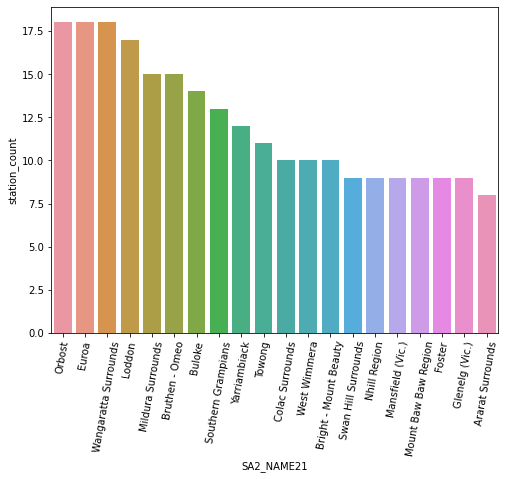

In [136]:
temp = station_population_plot_df.sort_values(by=['station_count'], ascending=False)[:20]
plt.figure(figsize=(8, 6))
plt.xticks(rotation=80)
sns.barplot(x="SA2_NAME21", y="station_count", data=temp)

<AxesSubplot:xlabel='area_km2', ylabel='station_count'>

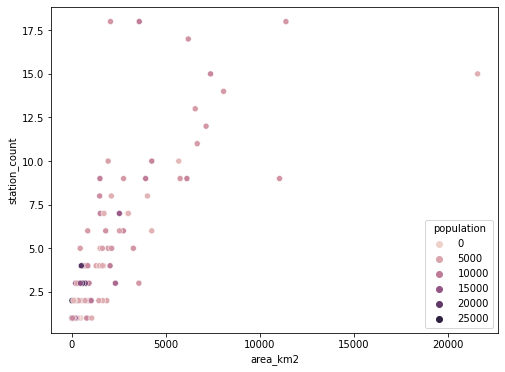

In [132]:
plt.figure(figsize=(8, 6))
sns.scatterplot(data=station_population_plot_df, x="area_km2", y="station_count", hue="population")

Not such related to population, but seems relatd to the area of that region. With the area become larger, the station count corelated increased. 

In [137]:
mapPlotData.head()

avg_sentiment  doc_count                           key  \
0       0.048477       17.0  Point Lonsdale - Queenscliff   
1       0.031366        7.0                        Towong   
2       0.026211       13.0              Trafalgar (Vic.)   
3       0.036747       94.0                      Warragul   
4       0.048046       37.0                Lakes Entrance   

                  sa2_name_2016          area_km2 sa2_maincode_2016  \
0  Point Lonsdale - Queenscliff  61.6734008789062         203031052   
1                        Towong  6668.72119140625         204031072   
2              Trafalgar (Vic.)  501.528900146484         205011078   
3                      Warragul  352.179107666016         205011079   
4                Lakes Entrance  214.035202026367         205021084   

  pop_density_2020_people_per_km2 SA2_CODE21                    SA2_NAME21  \
0                76.9537963867188  203031052  Point Lonsdale - Queenscliff   
1               0.910799980163574  204031072                        Towong   
2                16.2124004364014  205011078              Trafalgar (Vic.)   
3                60.8354988098145  205011079                      Warragul   
4                49.4310989379883  205021084                Lakes Entrance   

                                            geometry            Region  \
0  MULTIPOLYGON (((144.68579 -38.24574, 144.68507...               NaN   
1  POLYGON ((147.10965 -36.21650, 147.10958 -36.2...            Towong   
2  POLYGON ((146.01963 -38.21327, 146.01984 -38.2...  Trafalgar (Vic.)   
3  POLYGON ((145.89337 -38.14423, 145.89376 -38.1...          Warragul   
4  POLYGON ((147.82929 -37.82922, 147.82931 -37.8...    Lakes Entrance   

   station_count  
0            NaN  
1           11.0  
2            3.0  
3            1.0  
4            3.0

In [143]:
station_sentiment_plot_df = mapPlotData.dropna(axis=0, subset=['station_count'])

station_sentiment_plot_df.pop_density_2020_people_per_km2 = station_sentiment_plot_df.pop_density_2020_people_per_km2.astype(float)
station_sentiment_plot_df.area_km2 = station_sentiment_plot_df.area_km2.astype(float)
def calculate_popu(x):
    x['population'] = x.pop_density_2020_people_per_km2 * x.area_km2
    return x
station_sentiment_plot_df = station_sentiment_plot_df.apply(lambda x: calculate_popu(x), axis=1)
station_sentiment_plot_df[['SA2_NAME21', 'avg_sentiment', 'station_count', 'population']]

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


SA2_NAME21  avg_sentiment  station_count    population
1                         Towong       0.031366           11.0   6073.871129
2               Trafalgar (Vic.)       0.026211            3.0   8130.987360
3                       Warragul       0.036747            1.0  21424.991685
4                 Lakes Entrance       0.048046            3.0  10579.995248
6                         Foster       0.018665            9.0   9233.046910
..                           ...            ...            ...           ...
402                    Mooroopna            NaN            1.0   8137.001027
403  Shepparton Surrounds - East       0.000000            1.0   3879.987114
404              Colac Surrounds       0.000000           10.0   5408.043160
405                   Camperdown       0.015804            2.0   3450.999273
406          Corangamite - North       0.011404            6.0   5356.888608

[143 rows x 4 columns]

<AxesSubplot:xlabel='avg_sentiment', ylabel='station_count'>

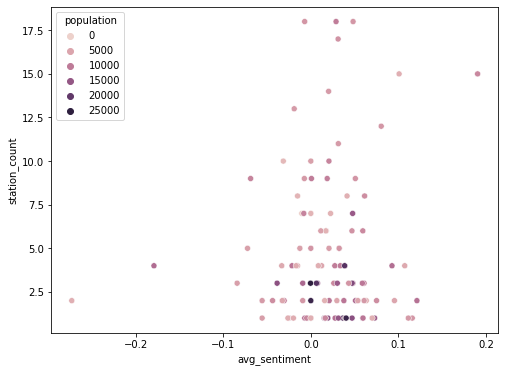

In [145]:
plt.figure(figsize=(8, 6))
sns.scatterplot(data=station_sentiment_plot_df, x="avg_sentiment", y="station_count", hue="population")